# Analysis Demonstration

### (things to talk about: how we ran analysis and gathered data, problems we ran into and how to solve them, how our functions could be used, things that surprised us, interesting conclusions, etc)

## Import Functions

In [1]:
# Packages
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math
import seaborn as sns
from collections import Counter
import scipy.stats as stats
import statsmodels.stats.api as sms

# Our Functions
from scrape_data import scrape_imdb, scrape_rotten_tomatoes, get_html_text
from clean_data_functions import clean_imdb, clean_rotten_tomatoes
from analysis_functions import list_averages, year_averages_plot, top_list_vals



## Use Our Functions to Scrape and Clean Data
Our functions allow you to scrape data from imdb and rotten tomatoes lists of movies. The two lists we are using for our data are https://editorial.rottentomatoes.com/guide/disney-100-essential-movies/ and https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=1 which goes on to have five pages of disney movies. After scraping we create a csv file of the raw data which we then pass to our cleaning functions. The raw data as well as the final cleaned datasets are included in the data folder.

In [11]:
# Scrape from Rotten Tomatoes

webpage = "https://editorial.rottentomatoes.com/guide/disney-100-essential-movies/"
rotten_tomatoes = scrape_rotten_tomatoes(webpage)
rotten_tomatoes.to_csv('data/rotten_tomatoes_raw.csv', index = False)

In [12]:
# Scrape from IMDB

webpages = ["https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=1", 
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=2",
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=3", 
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=4",
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=5"]

imdb = pd.DataFrame()
for webpage in webpages:
    imdb = pd.concat([imdb, scrape_imdb(webpage)])

imdb.to_csv('data/imdb_raw.csv', index = False)

In [2]:
# Clean Rotten Tomatoes Dataframe

rotten_tomatoes = pd.read_csv('data/rotten_tomatoes_raw.csv')

rotten_tomatoes = clean_rotten_tomatoes(rotten_tomatoes)

rotten_tomatoes.to_csv('data/rotten_tomatoes.csv', index = False)

In [3]:
# Clean IMDB Dataframe

imdb = pd.read_csv('data/imdb_raw.csv')
imdb = clean_imdb(imdb)

# Drop 19 since it has no reviews or data aside from name
imdb = imdb.drop(19, axis='index')

# Drop 170 since it is a DVD containing episodes from different shows and not a movie
imdb = imdb.drop(170, axis='index')

imdb.to_csv('data/imdb.csv', index = False)

## Comparisons
We can then merge the two datasets to run comparisons.

In [4]:
merged = rotten_tomatoes.merge(imdb, how= 'inner', on = ['title', 'year'])
merged = merged.rename(columns={'score_y': 'imdb_score', 'comparison_score': 'rotten_tomatoes_score'})
merged.to_csv('data/merged.csv', index = False)

In [5]:
print("IMDB Score: ")
print(merged.imdb_score.mean())
print("IMDB Standard Deviation: ")
print(merged.imdb_score.std())

print("Rotten Tomatoes Score: ")
print(merged.rotten_tomatoes_score.mean())
print("Rotten Tomatoes Standard Deviation: ")
print(merged.rotten_tomatoes_score.std())

IMDB Score: 
7.332258064516129
IMDB Standard Deviation: 
0.5238157015597767
Rotten Tomatoes Score: 
8.375268817204303
Rotten Tomatoes Standard Deviation: 
1.4312244616273653


(3.5, 10.5)

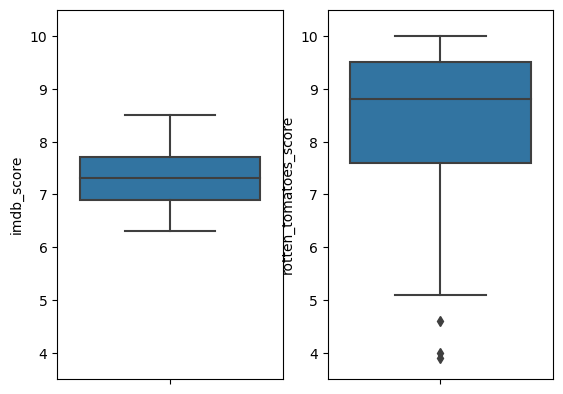

In [6]:
fig, axes = plt.subplots(1, 2)
sns.boxplot( y=merged["imdb_score"], ax = axes[0])
axes[0].set_ylim(3.5,10.5)
sns.boxplot( y=merged["rotten_tomatoes_score"], ax = axes[1])
axes[1].set_ylim(3.5,10.5)

In [7]:
cm = sms.CompareMeans(sms.DescrStatsW(merged.imdb_score), sms.DescrStatsW(merged.rotten_tomatoes_score))
print(cm.tconfint_diff(usevar='unequal'))

(-1.3560200752070943, -0.7300014301692479)


In [8]:
genre_ratings2 = list_averages(merged, merged['genre'], merged['imdb_score'])
genre_ratings2 = genre_ratings2.sort_values(by = 1)

genre_ratings3 = list_averages(merged, merged['genre'], merged['rotten_tomatoes_score'])
genre_ratings3[1] = genre_ratings3[1].astype(float)
genre_ratings3 = genre_ratings3.sort_values(by = 1)

genre_ratings2.merge(genre_ratings3, on = 0).rename(columns={0: 'Genre', '1_x': 'IMDB Score', '1_y': 'RT Score'})

,Genre,IMDB Score,RT Score
0,Sci-Fi,6.7000,7.3000
1,Mystery,6.9000,4.6000
2,History,6.9000,3.9000
3,Family,7.0694,8.0028
4,Fantasy,7.1167,7.8750
5,Romance,7.2000,9.0000
6,Drama,7.2148,7.9111
7,Sport,7.2750,8.0500
8,Adventure,7.3500,8.4583
9,Action,7.3700,7.8500


Continuing our comparisons, we can look at the average score for rotten tomatoes and for IMDB.

Here is the score by decade for IMDB.

In [9]:
pd.DataFrame(merged.groupby(merged['decade']).imdb_score.mean()).merge(pd.DataFrame(merged.groupby(merged['decade']).rotten_tomatoes_score.mean()), on = 'decade')

,imdb_score,rotten_tomatoes_score
decade,,
1930,7.600000,9.700000
1940,7.425000,9.525000
1950,7.257143,9.014286
1960,7.366667,8.500000
1970,7.050000,7.750000
1980,6.983333,7.916667
1990,7.330000,7.970000
2000,7.440000,8.520000
2010,7.336364,8.231818


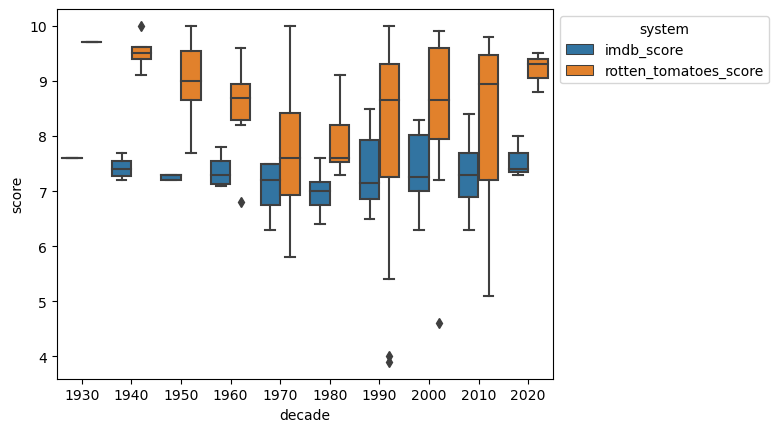

In [10]:
df = merged[['decade', 'imdb_score', 'rotten_tomatoes_score']]

df = pd.melt(df, id_vars=['decade'], value_vars=['imdb_score', 'rotten_tomatoes_score'], 
                   var_name='system', value_name='score')

ax = sns.boxplot(x='decade', y = 'score', data=df, hue='system')
sns.move_legend(ax, loc = "upper left", bbox_to_anchor=(1, 1))

And finally a graphical comparison.

Text(0.5, 1.0, '')

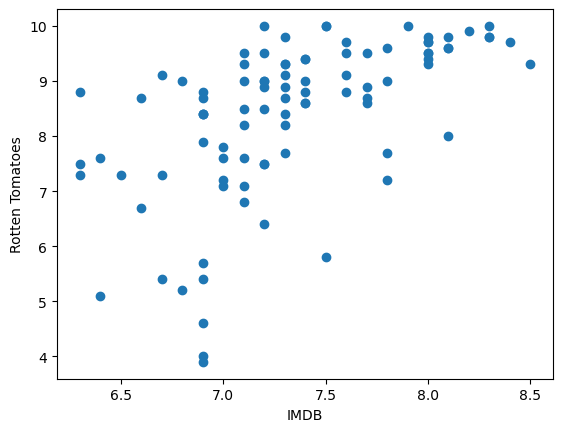

In [12]:
plt.scatter(merged.imdb_score, merged.rotten_tomatoes_score) 
plt.xlabel('IMDB')
plt.ylabel('Rotten Tomatoes')
plt.title('')

We can also run a hypothesis test on whether the scores for IMDB and Rotten Tomatoes are the same, from which we get a value of 4e-10, which is practically 0, so we reject the null hypothesis that they are the same.

In [13]:
stats.ttest_ind(a=merged['imdb_score'], b=merged['rotten_tomatoes_score'], equal_var=True)

TtestResult(statistic=-6.59972177742585, pvalue=4.2624179743929416e-10, df=184.0)

## IMDB Score Influencers

In [14]:
imdb.corr(numeric_only = True)

,year,score,runtime,gross,decade
year,1.000000,-0.062053,0.201130,0.315172,0.989915
score,-0.062053,1.000000,0.212722,0.528059,-0.056349
runtime,0.201130,0.212722,1.000000,0.376073,0.201399
gross,0.315172,0.528059,0.376073,1.000000,0.309381
decade,0.989915,-0.056349,0.201399,0.309381,1.000000


Below we utilize our list_averages function to get the average score for each director included in the directors column. Here we look at the top 20 directors.

In [15]:
top_directors = top_list_vals(imdb['director'], 20)

director_scores = list_averages(imdb, imdb['director'], imdb['score'])

top_scores = director_scores[director_scores[0].isin(list(top_directors[0]))]

top_directors.merge(top_scores, 'outer', on = [0]).rename(columns={0: 'Director', '1_x': 'Movie Count', '1_y': 'Average IMDB Score'})

,Director,Movie Count,Average IMDB Score
0,Robert Stevenson,18,6.4889
1,Norman Tokar,14,6.3571
2,Vincent McEveety,13,5.7692
3,Hamilton Luske,12,6.9750
4,James Algar,11,7.0364
5,Clyde Geronimi,11,6.9364
6,Jack Kinney,10,6.7900
7,Wilfred Jackson,9,7.2556
8,Ron Clements,7,7.4143
9,John Musker,7,7.4143


In [16]:
top_actors = top_list_vals(imdb['actors'], 20)

actor_scores = list_averages(imdb, imdb['actors'], imdb['score'])

top_scores = actor_scores[actor_scores[0].isin(list(top_actors[0]))] 

top_actors.merge(top_scores, 'outer', on = [0]).rename(columns={0: 'Actor', '1_x': 'Movie Count', '1_y': 'Average IMDB Score'})

,Actor,Movie Count,Average IMDB Score
0,Dean Jones,11,6.0545
1,Tim Allen,10,6.5900
2,Jim Cummings,9,6.3111
3,Johnny Depp,8,6.8375
4,Kurt Russell,8,6.0625
5,David Ogden Stiers,7,6.3000
6,Don Knotts,7,5.9571
7,Hayley Mills,7,6.7429
8,Joe Flynn,7,5.9429
9,Fred MacMurray,7,6.3286


We use the same function to compute ratings for each genre. And then compare the genre ratings between imdb and rotten tomatoes.

In [17]:
genre_ratings = list_averages(imdb, imdb['genre'], imdb['score'])
genre_ratings.sort_values(by = 1)

,0,1
13,Crime,5.7250
15,Music,5.7556
14,Western,5.9444
20,Horror,6.1000
2,Comedy,6.1640
5,Family,6.1742
18,Romance,6.2125
6,Fantasy,6.3684
7,Drama,6.3986
21,War,6.4000


Another object of interest is the scores by movie rating.

<Axes: xlabel='rating', ylabel='score'>

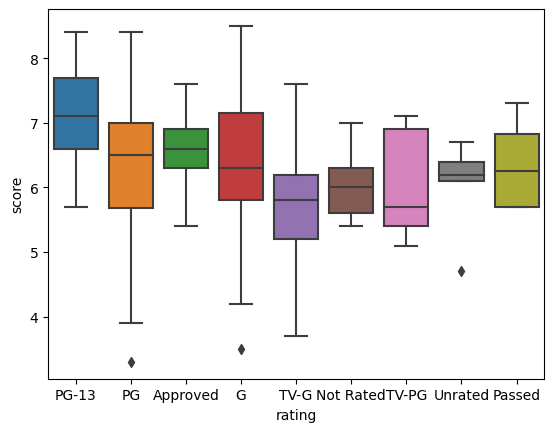

In [18]:
imdb.groupby(imdb['rating']).score.mean()
sns.boxplot(x='rating', y='score', data=imdb)

## Trends Over Time

We can also look at trends over the years in the following graphs.

In [38]:

genres = list(filter(None, list(imdb['genre'].explode().unique())))

# Initialize a dictionary to store value counts for each genre in each decade
genre_counts_by_decade = {}

# Iterate through each genre and calculate the count for each decade
for genre in genres:
    # Filter rows where the genre is included in the list and 'decade' is not null
    filtered_rows = imdb[imdb['genre'].apply(lambda x: genre in x if x is not None else 0)]
    genre_counts = filtered_rows['decade'].value_counts().sort_index()
    
    # Store the counts in the dictionary
    genre_counts_by_decade[genre] = genre_counts

# Convert the dictionary to a pandas DataFrame
genre_year_count = pd.DataFrame(genre_counts_by_decade)
genre_year_count.replace(np.nan, 0, inplace=True)
genre_year_count.astype(int).sort_index().iloc[:9,:8]

,Action,Adventure,Comedy,Sci-Fi,Animation,Family,Fantasy,Drama
decade,,,,,,,,
1930,0,1,0,0,1,1,0,0
1940,0,5,7,0,11,6,1,3
1950,2,19,4,0,5,25,3,11
1960,1,19,28,6,2,42,5,15
1970,4,18,33,5,5,32,7,6
1980,3,19,9,1,7,20,4,7
1990,10,52,59,3,26,45,7,33
2000,23,82,101,0,55,70,14,39
2010,33,73,46,10,30,33,15,24


<Axes: xlabel='year', ylabel='Density'>

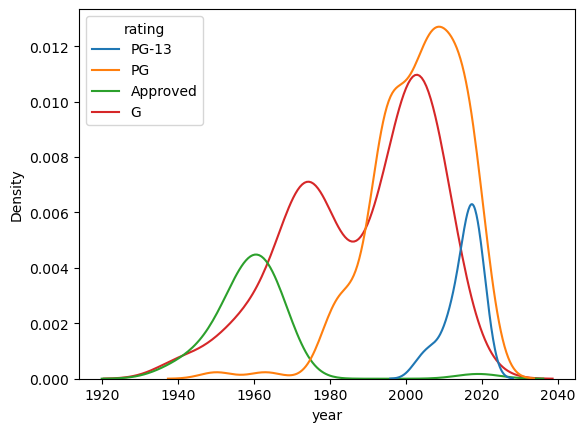

In [20]:
main_ratings = imdb[imdb['rating'].isin(['PG-13', 'PG', 'G', 'Approved'])]

sns.kdeplot(data=main_ratings, x="year", hue="rating")

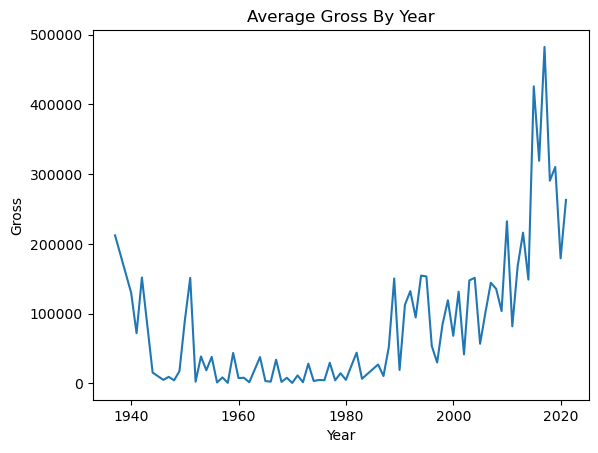

In [21]:
year_averages_plot(imdb, 'year', 'gross')

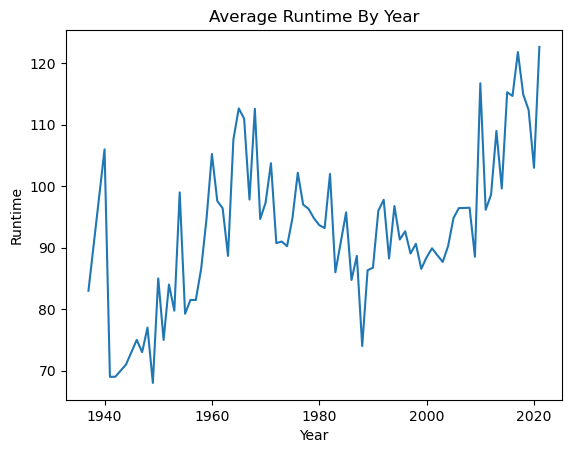

In [8]:
year_averages_plot(imdb, 'year', 'runtime')

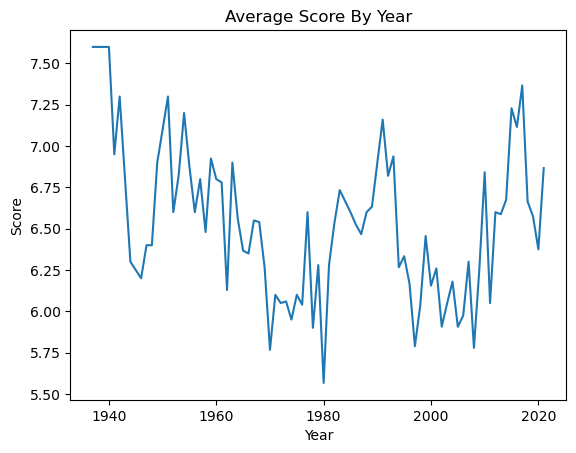

In [9]:
year_averages_plot(imdb, 'year', 'score')

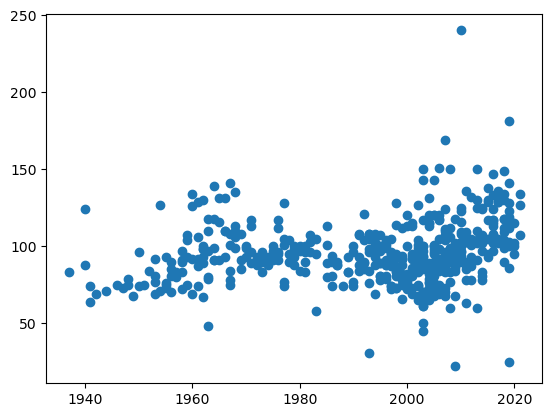

In [144]:
plt.scatter(x = imdb.year, y = imdb.runtime) 

## Further Comparisons
And finally the complete pairplot.

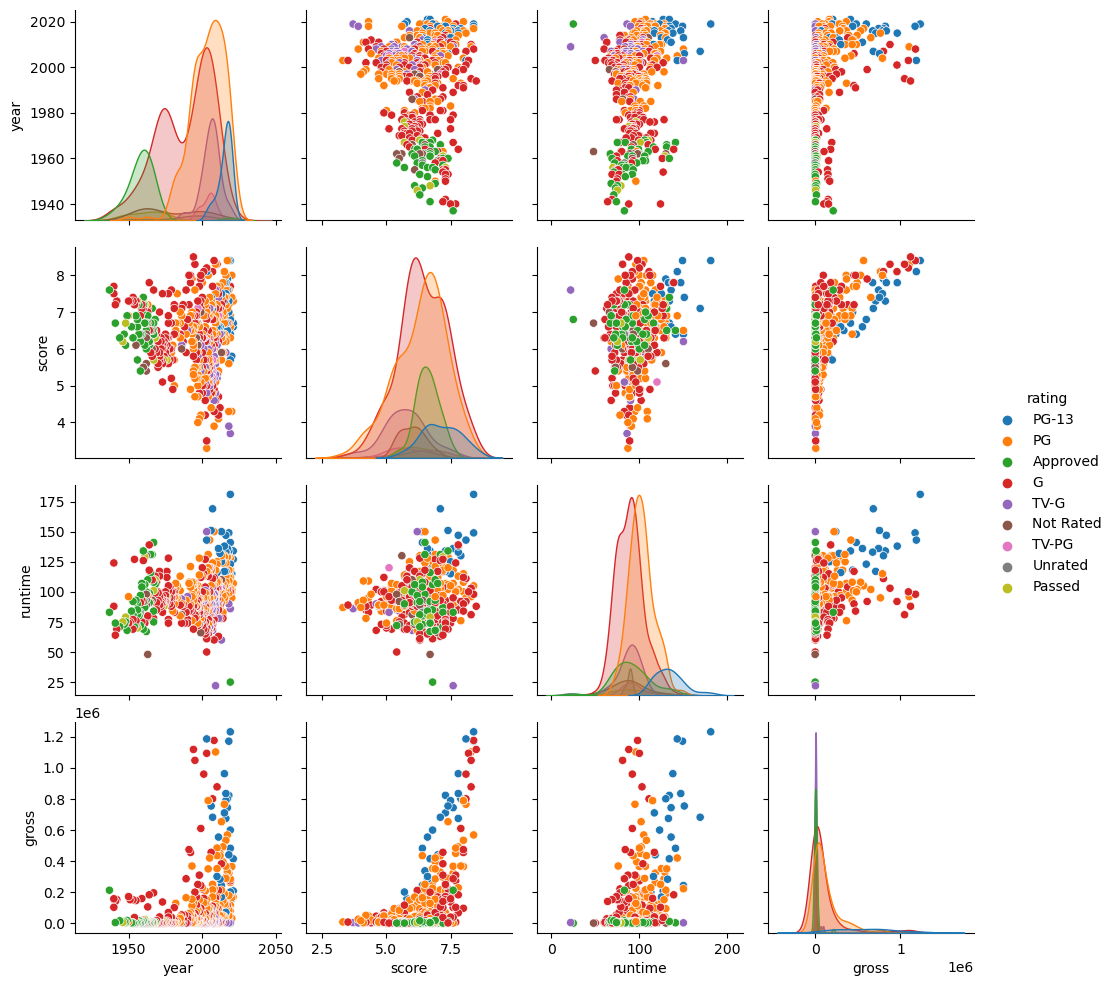

In [42]:
imdb['gross'] = imdb['gross'].astype(int)
sns.pairplot(imdb[['year', 'score', 'runtime', 'gross', 'rating']], hue = 'rating')